# Case Study 2 — T2D Biomarker Analysis  
中英双语说明 | Bilingual Instructions

**Usage / 使用方法**  
1) Put your data file `week5_data_CS2.txt` in the same folder as this notebook.
   将数据文件 `week5_data_CS2.txt` 与本 ipynb 放在同一目录。
2) Run the cells from top to bottom, it will compute group tests, pairwise comparisons, effect sizes,
   and ROC/AUC + bootstrap CI + Youden threshold, then draw histograms, boxplot and ROC curves.  
   自上而下依次运行，自动完成三组比较、两两比较、效应量、以及 ROC/AUC（含自助法置信区间）、Youden 阈值，并绘制直方图、箱线图、ROC曲线与阈值可视化。

In [1]:
# === Imports & Settings | 导入与设置 ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import roc_curve, roc_auc_score

# NOTE: Only matplotlib is used for plotting; no seaborn; no specific colors.
# 仅使用 matplotlib 作图；不使用 seaborn；不指定颜色。

In [2]:
# === Load data | 读取数据 ===
path = 'week5_data_CS2.txt'  # 如果路径不同，请修改此处
df = pd.read_csv(path, sep=r"\s+", engine='python')
groups = ["Controls","Prediabetics","T2D_Cases"]
assert all(g in df.columns for g in groups), f"Columns not found: {groups}"
print(df.head())
print("\nCounts by group:", {g: df[g].dropna().shape[0] for g in groups})

   Controls  Prediabetics  T2D_Cases
0        14            24         28
1        15            20         21
2        12            17         26
3        28            24         35
4        15            25         30

Counts by group: {'Controls': 30, 'Prediabetics': 30, 'T2D_Cases': 30}


In [3]:
# === Descriptive stats | 描述统计 ===
desc = df.agg(['count','mean','std'])[groups].T.rename(columns={'count':'n','mean':'Mean','std':'SD'})
print("Descriptives (n, Mean, SD) by group:\n", desc)

print("\nShapiro-Wilk normality (W, p):")
for g in groups:
    sw = stats.shapiro(df[g])
    print(f"{g}: (W={sw.statistic:.3f}, p={sw.pvalue:.5f})")

lev = stats.levene(df['Controls'], df['Prediabetics'], df['T2D_Cases'], center='median')
print(f"\nLevene equal-variance: stat={lev.statistic:.3f}, p={lev.pvalue:.5f}")

anova = stats.f_oneway(df['Controls'], df['Prediabetics'], df['T2D_Cases'])
kw = stats.kruskal(df['Controls'], df['Prediabetics'], df['T2D_Cases'])
print(f"\nOne-way ANOVA: F={anova.statistic:.3f}, p={anova.pvalue:.3g}")
print(f"Kruskal-Wallis: H={kw.statistic:.3f}, p={kw.pvalue:.3g}")

Descriptives (n, Mean, SD) by group:
                  n       Mean        SD
Controls      30.0  15.400000  4.522739
Prediabetics  30.0  21.000000  2.665229
T2D_Cases     30.0  30.666667  5.938381

Shapiro-Wilk normality (W, p):
Controls: (W=0.952, p=0.19287)
Prediabetics: (W=0.933, p=0.05897)
T2D_Cases: (W=0.959, p=0.28386)

Levene equal-variance: stat=4.088, p=0.02010

One-way ANOVA: F=85.449, p=2.96e-21
Kruskal-Wallis: H=62.845, p=2.26e-14


In [4]:
# === Pairwise comparisons | 两两比较（Welch t + Mann–Whitney + Holm） ===
pairs = [("T2D_Cases","Controls"), ("T2D_Cases","Prediabetics"), ("Prediabetics","Controls")]

def welch_t(a,b):
    return stats.ttest_ind(df[a], df[b], equal_var=False)
def mann_whitney(a,b):
    return stats.mannwhitneyu(df[a], df[b], alternative='two-sided')
def cohens_d(a,b):
    x, y = df[a].values, df[b].values
    return (x.mean()-y.mean())/np.sqrt((x.var(ddof=1)+y.var(ddof=1))/2.0)
def cliffs_delta(a,b):
    x, y = df[a].values, df[b].values
    cnt = 0
    for xi in x:
        cnt += np.sum(xi > y) - np.sum(xi < y)
    return cnt/(len(x)*len(y))
def holm(pvals):
    m = len(pvals)
    order = np.argsort(pvals)
    adj = np.empty(m)
    prev = 0.0
    for i, idx in enumerate(order):
        rank = m - i
        adj_p = pvals[idx]*rank
        adj_p = max(adj_p, prev)
        adj[idx] = min(adj_p, 1.0)
        prev = adj[idx]
    return adj

welch = [welch_t(*p) for p in pairs]
mw = [mann_whitney(*p) for p in pairs]
d_vals = [cohens_d(*p) for p in pairs]
delta_vals = [cliffs_delta(*p) for p in pairs]
welch_p = np.array([w.pvalue for w in welch])
mw_p = np.array([u.pvalue for u in mw])
welch_adj = holm(welch_p.copy())
mw_adj = holm(mw_p.copy())

print("Pairwise comparisons (Welch t):")
for (a,b), w, p, q, d in zip(pairs, welch, welch_p, welch_adj, d_vals):
    print(f"{a} vs {b}: t={w.statistic:.3f}, p={p:.3g}, Holm p={q:.3g}, Cohen d={d:.3f}")
print("\nPairwise comparisons (Mann–Whitney):")
for (a,b), u, p, q, dlt in zip(pairs, mw, mw_p, mw_adj, delta_vals):
    print(f"{a} vs {b}: U={u.statistic:.3f}, p={p:.3g}, Holm p={q:.3g}, Cliff delta={dlt:.3f}")

Pairwise comparisons (Welch t):
T2D_Cases vs Controls: t=11.202, p=1.01e-15, Holm p=3.03e-15, Cohen d=2.892
T2D_Cases vs Prediabetics: t=8.134, p=4.99e-10, Holm p=9.98e-10, Cohen d=2.100
Prediabetics vs Controls: t=5.843, p=4.66e-07, Holm p=4.66e-07, Cohen d=1.509

Pairwise comparisons (Mann–Whitney):
T2D_Cases vs Controls: U=881.500, p=1.79e-10, Holm p=5.37e-10, Cliff delta=0.959
T2D_Cases vs Prediabetics: U=856.000, p=1.88e-09, Holm p=3.75e-09, Cliff delta=0.902
Prediabetics vs Controls: U=777.000, p=1.26e-06, Holm p=1.26e-06, Cliff delta=0.727


In [5]:
# === ROC / AUC (T2D vs non-T2D) + bootstrap CI + Youden threshold ===
y_true = np.concatenate([np.zeros(df['Controls'].shape[0] + df['Prediabetics'].shape[0]),
                         np.ones(df['T2D_Cases'].shape[0])])
y_score = np.concatenate([df['Controls'].values, df['Prediabetics'].values, df['T2D_Cases'].values])

auc = roc_auc_score(y_true, y_score)
fpr, tpr, thr = roc_curve(y_true, y_score)

# Bootstrap 95% CI
rng = np.random.default_rng(123)
B = 3000
N = len(y_true)
aucs = []
for _ in range(B):
    idx = rng.integers(0, N, size=N)
    aucs.append(roc_auc_score(y_true[idx], y_score[idx]))
ci_low, ci_high = np.percentile(aucs, [2.5, 97.5])

# Youden J = TPR - FPR
youden = tpr - fpr
best_i = np.argmax(youden)
best_thr = thr[best_i]

pred = (y_score >= best_thr).astype(int)
tp = np.sum((pred==1) & (y_true==1))
tn = np.sum((pred==0) & (y_true==0))
fp = np.sum((pred==1) & (y_true==0))
fn = np.sum((pred==0) & (y_true==1))
sens = tp/(tp+fn) if (tp+fn)>0 else np.nan
spec = tn/(tn+fp) if (tn+fp)>0 else np.nan
ppv  = tp/(tp+fp) if (tp+fp)>0 else np.nan
npv  = tn/(tn+fn) if (tn+fn)>0 else np.nan
acc  = (tp+tn)/N

print(f"AUC={auc:.3f} (95% CI: {ci_low:.3f}, {ci_high:.3f})")
print(f"Optimal threshold (Youden): {best_thr}")
print(f"Sensitivity={sens:.3f}, Specificity={spec:.3f}, PPV={ppv:.3f}, NPV={npv:.3f}, Accuracy={acc:.3f}")

AUC=0.965 (95% CI: 0.916, 0.997)
Optimal threshold (Youden): 25.0
Sensitivity=0.933, Specificity=0.917, PPV=0.848, NPV=0.965, Accuracy=0.922


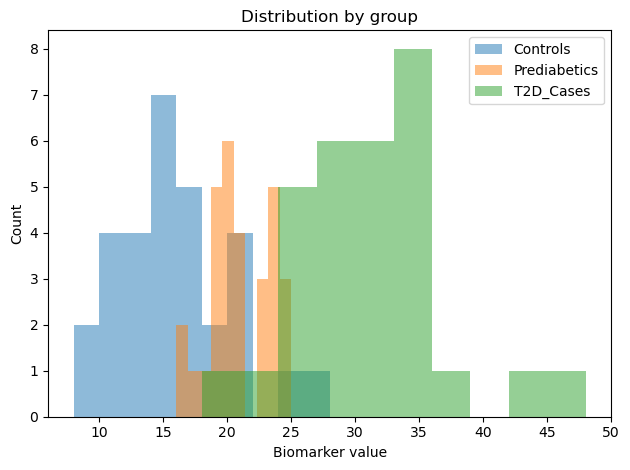

/var/folders/cx/jyf_qmx92mjcl9g6ql6dhl580000gn/T/ipykernel_29958/362716775.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df['Controls'].values, df['Prediabetics'].values, df['T2D_Cases'].values],


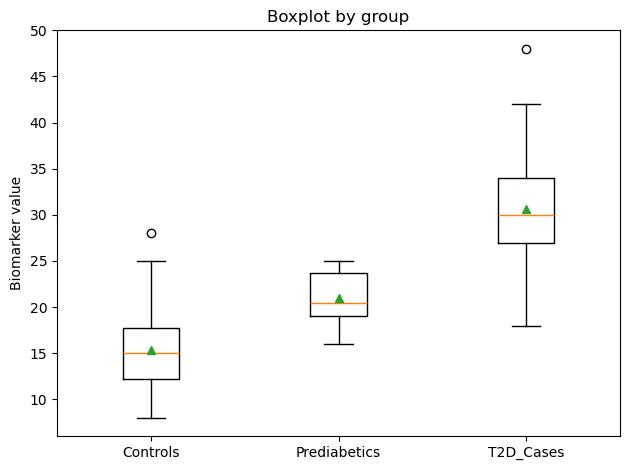

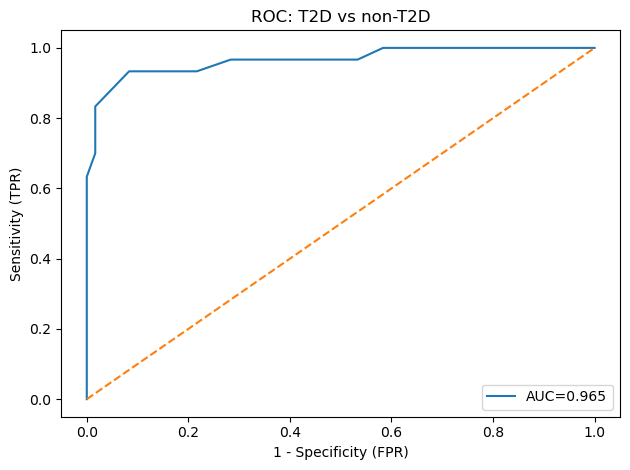

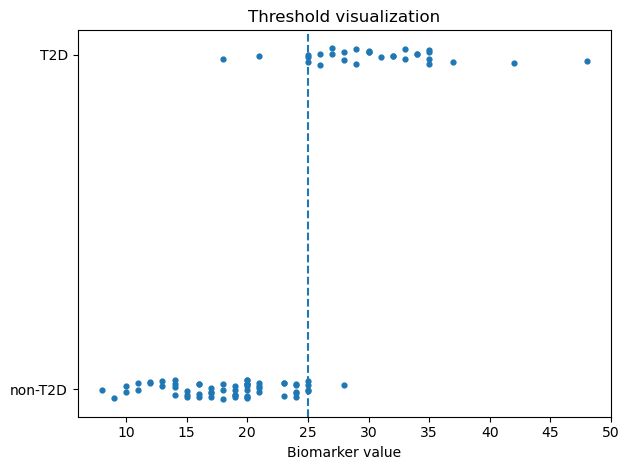

In [6]:
# === Plots | 作图（每图一事） ===
# 1) Histograms by group | 三组直方图（叠加）
plt.figure()
plt.hist(df['Controls'].values, bins=10, alpha=0.5, label='Controls')
plt.hist(df['Prediabetics'].values, bins=10, alpha=0.5, label='Prediabetics')
plt.hist(df['T2D_Cases'].values, bins=10, alpha=0.5, label='T2D_Cases')
plt.xlabel('Biomarker value'); plt.ylabel('Count')
plt.title('Distribution by group'); plt.legend(); plt.tight_layout(); plt.show()

# 2) Boxplot | 箱线图
plt.figure()
plt.boxplot([df['Controls'].values, df['Prediabetics'].values, df['T2D_Cases'].values],
            labels=['Controls','Prediabetics','T2D_Cases'], showmeans=True)
plt.ylabel('Biomarker value'); plt.title('Boxplot by group'); plt.tight_layout(); plt.show()

# 3) ROC curve | ROC 曲线
plt.figure()
from sklearn.metrics import roc_curve
fpr, tpr, thr = roc_curve(np.concatenate([np.zeros(df['Controls'].shape[0]+df['Prediabetics'].shape[0]), np.ones(df['T2D_Cases'].shape[0])]),
                          np.concatenate([df['Controls'].values, df['Prediabetics'].values, df['T2D_Cases'].values]))
auc = roc_auc_score(np.concatenate([np.zeros(df['Controls'].shape[0]+df['Prediabetics'].shape[0]), np.ones(df['T2D_Cases'].shape[0])]),
                    np.concatenate([df['Controls'].values, df['Prediabetics'].values, df['T2D_Cases'].values]))
plt.plot(fpr, tpr, label=f'AUC={auc:.3f}')
plt.plot([0,1],[0,1],'--')
plt.xlabel('1 - Specificity (FPR)'); plt.ylabel('Sensitivity (TPR)')
plt.title('ROC: T2D vs non-T2D'); plt.legend(loc='lower right'); plt.tight_layout(); plt.show()

# 4) Threshold visualization | 阈值可视化（散点+阈值线）
y_true = np.concatenate([np.zeros(df['Controls'].shape[0] + df['Prediabetics'].shape[0]),
                         np.ones(df['T2D_Cases'].shape[0])])
y_score = np.concatenate([df['Controls'].values, df['Prediabetics'].values, df['T2D_Cases'].values])
fpr, tpr, thr = roc_curve(y_true, y_score)
youden = tpr - fpr
best_i = np.argmax(youden)
best_thr = thr[best_i]
rng = np.random.default_rng(42)
jitter = (rng.random(len(y_score)) - 0.5) * 0.06
plt.figure()
plt.scatter(y_score, y_true + jitter, s=12)
plt.axvline(best_thr, linestyle='--')
plt.yticks([0,1], ['non-T2D','T2D'])
plt.xlabel('Biomarker value'); plt.title('Threshold visualization'); plt.tight_layout(); plt.show()